In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[]

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
normal_df = pd.read_csv("/content/ptbdb_normal.csv")
anomaly_df = pd.read_csv("/content/ptbdb_abnormal.csv")
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64,0.000000000000000000e+00.65
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 188)
Shape of Abnormal data (8254, 188)


In [ ]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(normal_df), 2)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Normal")

    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Anomaly")

    plt.tight_layout()
    plt.show()

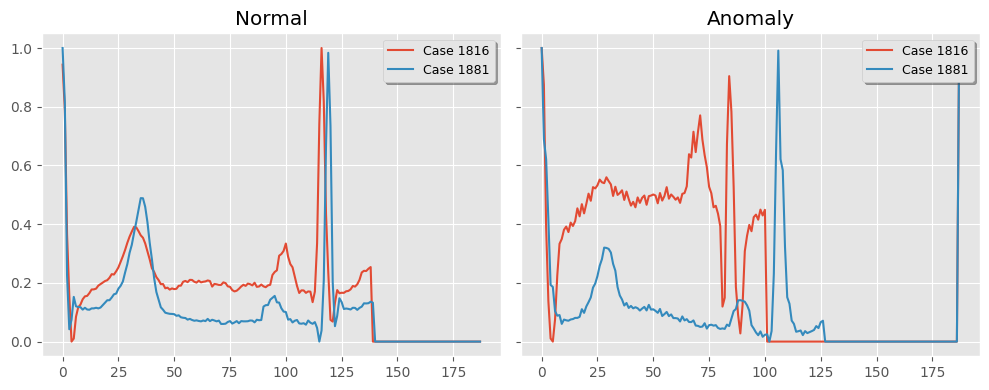

In [ ]:
plot_sample(normal_df, anomaly_df)

In [ ]:
CLASS_NAMES = ["Normal", "Anomaly"]

normal_df_copy = normal_df.copy()
anomaly_df_copy = anomaly_df.copy()
print(anomaly_df_copy.columns.equals(normal_df_copy.columns))

False


In [ ]:
normal_df_copy = normal_df_copy.set_axis(range(1, 189), axis=1)
anomaly_df_copy = anomaly_df_copy.set_axis(range(1, 189), axis=1)
normal_df_copy = normal_df_copy.assign(target = CLASS_NAMES[0])
anomaly_df_copy = anomaly_df_copy.assign(target = CLASS_NAMES[1])


df = pd.concat((normal_df_copy, anomaly_df_copy))

In [ ]:
def plot_smoothed_mean(data, class_name = "normal", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

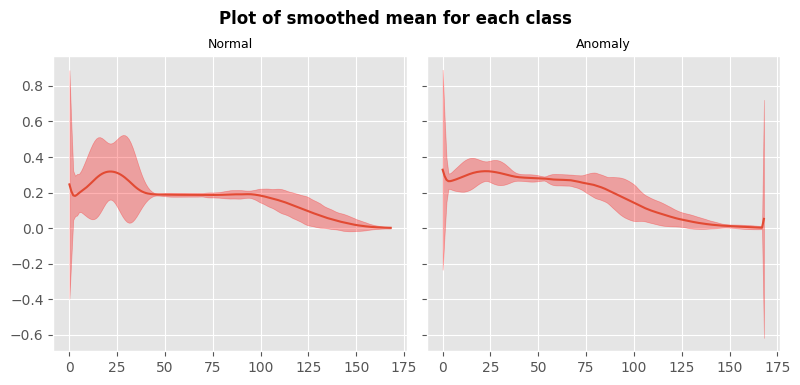

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("target")
    data = data_group.get_group(label).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=20, ax=axes[i-1])
fig.suptitle("Plot of smoothed mean for each class", y=0.95, weight="bold")
plt.tight_layout()

In [ ]:
normal_df.drop("target", axis=1, errors="ignore", inplace=True)
normal = normal_df.to_numpy()
anomaly_df.drop("target", axis=1, errors="ignore", inplace=True)
anomaly = anomaly_df.to_numpy()

X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, anomaly shape: {anomaly.shape}")

Train shape: (3438, 188), Test shape: (607, 188), anomaly shape: (8254, 188)


In [ ]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


input_dim = X_train.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

Model: "auto_encoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 47, 32)            6816      
                                                                 
 sequential_9 (Sequential)   (None, 188)               2271900   
                                                                 
Total params: 2278716 (8.69 MB)
Trainable params: 2278332 (8.69 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [ ]:
epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.3, callbacks=[early_stopping])

Epoch 1/100
38/38 [==============================] - 8s 111ms/step - loss: 6.3349 - val_loss: 2.5556
Epoch 2/100
38/38 [==============================] - 4s 102ms/step - loss: 2.4836 - val_loss: 2.5259
Epoch 3/100
38/38 [==============================] - 5s 142ms/step - loss: 1.6959 - val_loss: 1.3545
Epoch 4/100
38/38 [==============================] - 4s 105ms/step - loss: 1.1596 - val_loss: 1.0299
Epoch 5/100
38/38 [==============================] - 5s 121ms/step - loss: 0.8111 - val_loss: 0.8259
Epoch 6/100
38/38 [==============================] - 6s 149ms/step - loss: 0.5994 - val_loss: 0.5457
Epoch 7/100
38/38 [==============================] - 5s 124ms/step - loss: 0.3941 - val_loss: 0.3454
Epoch 8/100
38/38 [==============================] - 5s 122ms/step - loss: 0.2040 - val_loss: 0.2921
Epoch 9/100
38/38 [==============================] - 4s 115ms/step - loss: 0.2026 - val_loss: 0.2056
Epoch 10/100
38/38 [==============================] - 4s 101ms/step - loss: 0.1420 - val_lo

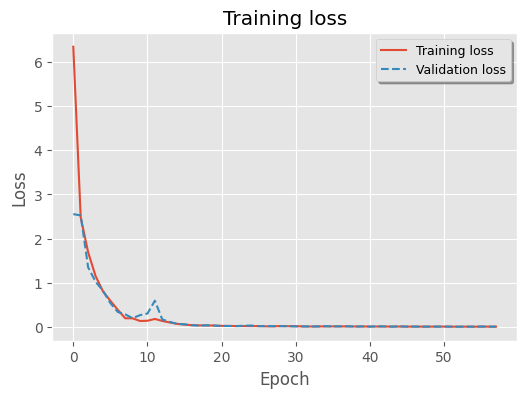

In [ ]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
train_mae = model.evaluate(X_train, X_train, verbose=0)
test_mae = model.evaluate(X_test, X_test, verbose=0)
anomaly_mae = model.evaluate(anomaly_df, anomaly_df, verbose=0)

print("Training dataset error: ", train_mae)
print("Testing dataset error: ", test_mae)
print("Anormaly dataset error: ", anomaly_mae)

Training dataset error:  0.013099598698318005
Testing dataset error:  0.013809597119688988
Anormaly dataset error:  nan


In [ ]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

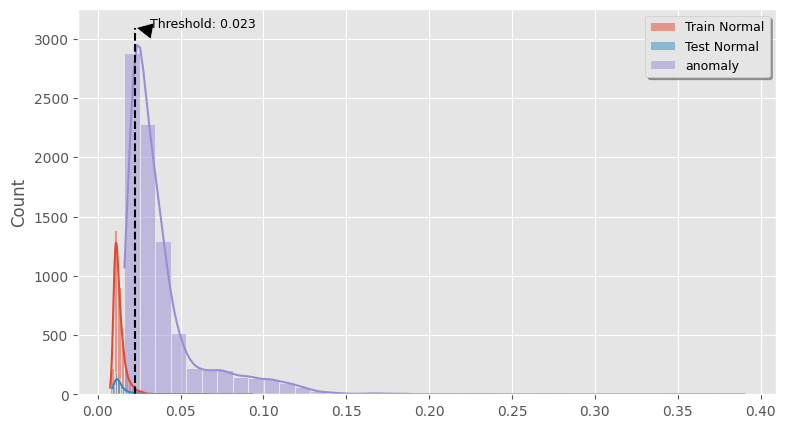

In [ ]:
_, train_loss = predict(model, X_train)
_, test_loss = predict(model, X_test)
_, anomaly_loss = predict(model, anomaly)
threshold = np.mean(train_loss) + 2*np.std(train_loss) # Setting threshold for distinguish normal data from anomalous data

bins = 40
plt.figure(figsize=(9, 5), dpi=100)
sns.histplot(train_loss, bins=bins, kde=True, label="Train Normal")
sns.histplot(test_loss, bins=bins, kde=True, label="Test Normal")
sns.histplot(anomaly_loss, bins=bins, kde=True, label="anomaly")

ax = plt.gca()  # Get the current Axes
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[-1], color="k", ls="--")
plt.annotate(f"Threshold: {threshold:.3f}", xy=(threshold, ylim[-1]), xytext=(threshold+0.009, ylim[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.show()

In [ ]:
def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label = "Predicted",color='b')
    ax.fill_between(range(1, 189), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True,
              facecolor="inherit", loc=1, fontsize=7)
#                bbox_to_anchor = (0, 0, 0.8, 0.25))

    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

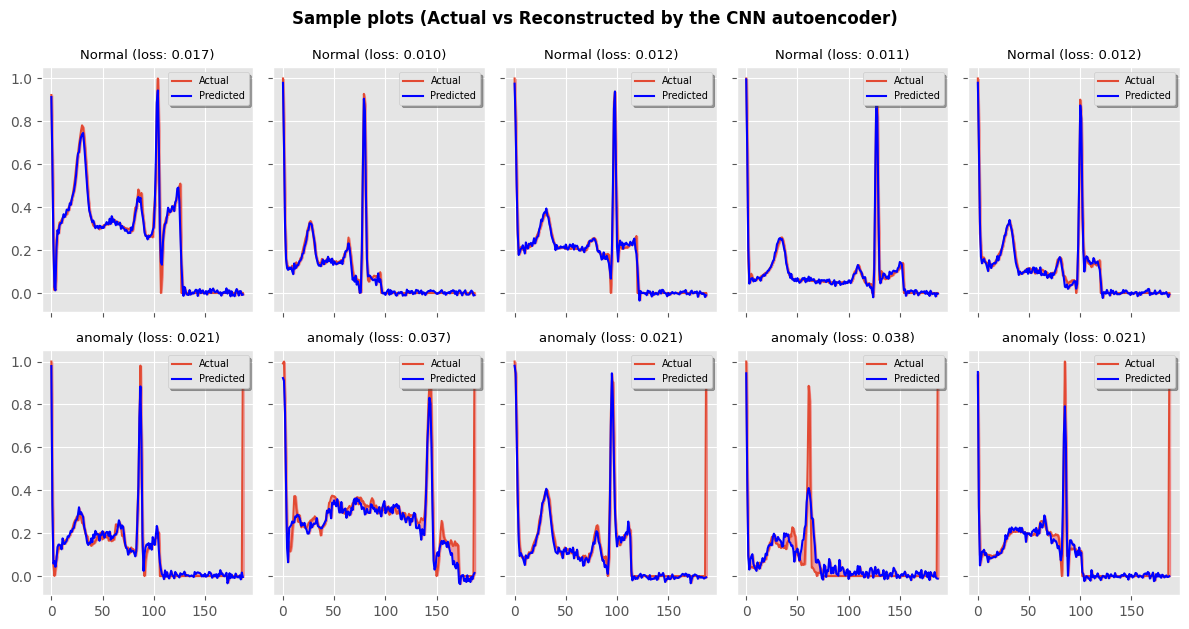

In [ ]:
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6))
random_indexes = np.random.randint(0, len(X_train), size=5)

for i, idx in enumerate(random_indexes):
    data = X_train[[idx]]
    plot_examples(model, data, ax=axes[0, i], title="Normal")

for i, idx in enumerate(random_indexes):
    data = anomaly[[idx]]
    plot_examples(model, data, ax=axes[1, i], title="anomaly")

plt.tight_layout()
fig.suptitle("Sample plots (Actual vs Reconstructed by the CNN autoencoder)", y=1.04, weight="bold")
fig.savefig("autoencoder.png")
plt.show()

In [ ]:
def evaluate_model(model, data):
    pred, loss = predict(model, data)
    if id(data) == id(anomaly):
        accuracy = np.sum(loss > threshold)/len(data)
    else:
        accuracy = np.sum(loss <= threshold)/len(data)
    return f"Accuracy: {accuracy:.2%}"

In [ ]:
print("Training", evaluate_model(model, X_train))
print("Testing", evaluate_model(model, X_test))
print("Anomaly", evaluate_model(model, anomaly))

Training Accuracy: 94.42%
Testing Accuracy: 92.42%
Anomaly Accuracy: 13.58%


In [ ]:
def prepare_labels(model, train, test, anomaly, threshold=threshold):
    ytrue = np.concatenate((np.ones(len(X_train)+len(X_test), dtype=int), np.zeros(len(anomaly), dtype=int)))
    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, anomaly_loss = predict(model, anomaly)
    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    anomaly_pred = (anomaly_loss < threshold).numpy().astype(int)
    ypred = np.concatenate((train_pred, test_pred, anomaly_pred))

    return ytrue, ypred

In [ ]:
def plot_confusion_matrix(model, train, test, anomaly, threshold=threshold):
    ytrue, ypred = prepare_labels(model, train, test, anomaly, threshold=threshold)
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)
    print(f"""\
        Accuracy: {accuracy:.2%}
        Precision: {precision:.2%}
        Recall: {recall:.2%}
        f1: {f1:.2%}\n
        """)

    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Anomaly", "Normal"]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix", weight="bold")
    plt.tight_layout()

        Accuracy: 84.97%
        Precision: 69.48%
        Recall: 96.86%
        f1: 80.92%

        


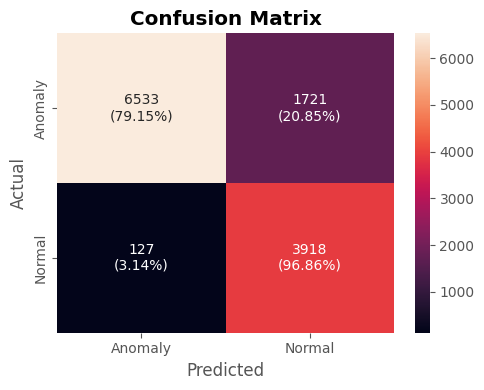

In [ ]:
plot_confusion_matrix(model, X_train, X_test, anomaly, threshold=threshold)

In [ ]:
ytrue, ypred = prepare_labels(model, X_train, X_test, anomaly, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Normal       0.98      0.79      0.88      8254
     Anomaly       0.69      0.97      0.81      4045

    accuracy                           0.85     12299
   macro avg       0.84      0.88      0.84     12299
weighted avg       0.89      0.85      0.85     12299

